<a href="https://colab.research.google.com/github/anjuunni/Sample/blob/main/Frauddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [3]:
filename="Fraud (1).csv"

In [4]:
fraud_df=pd.read_csv(filename)

###Understanding Data

In [5]:
fraud_df.head()

step      type    amount  ... newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT   9839.64  ...            0.0        0               0
1     1   PAYMENT   1864.28  ...            0.0        0               0
2     1  TRANSFER    181.00  ...            0.0        1               0
3     1  CASH_OUT    181.00  ...            0.0        1               0
4     1   PAYMENT  11668.14  ...            0.0        0               0

[5 rows x 11 columns]

In [6]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
fraud_df.shape

(6362620, 11)

###1.Data cleaning including missing values, outliers and multi-collinearity. 

In [8]:
fraud_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
fraud_df.dropna(inplace=True)

In [10]:
fraud_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

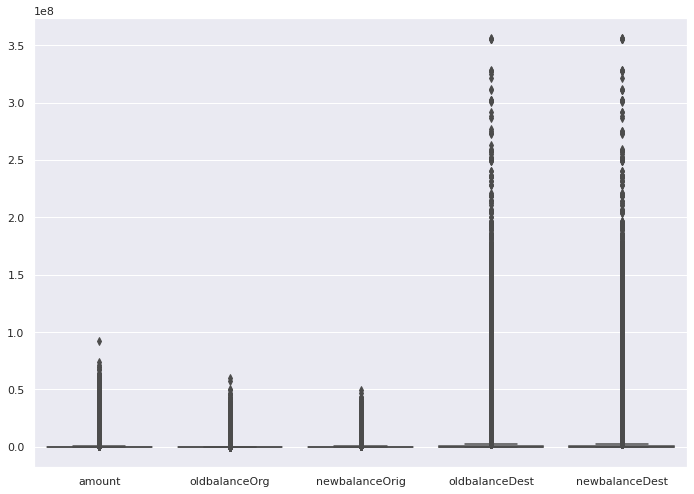

In [11]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(data=fraud_df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]);

In [12]:
fraud_df=fraud_df[(np.abs(stats.zscore(fraud_df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']])) < 3).all(axis=1)]


In [13]:
fraud_df.shape

(6090589, 11)

In [14]:
def calc_vif(X):

    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

 Usually multicollinearity is a problem for regression tasks.For nonparametric models such as decision trees, it’s possible that there might be some danger in overfitting the model if the level of correlation between features in the training set doesn’t generalize to unseen data.Variance Inflation Factor (VIF) is used to detect the presence of multicollinearity.VIF tells us about how well an independent variable is predictable using the other independent variables.It is always desirable to have VIF value as small as possible, but it can lead to many significant independent variables to be removed from the dataset. Therefore we can take VIF = 10 as a threshold

In [15]:
multi_df=fraud_df.filter(['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)
calc_vif(multi_df)

variables         VIF
0          amount    3.252225
1   oldbalanceOrg  360.979417
2  newbalanceOrig  372.667232
3  oldbalanceDest  122.954579
4  newbalanceDest  135.161606

We found that there is high collinearity for 4 variables .We will delete very high vif features.


In [16]:
fraud_df=fraud_df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)

In [17]:
inputs=fraud_df.drop(['isFraud'],axis=1)
target=fraud_df['isFraud']

In [18]:
inputs.head()

step      type    amount     nameOrig     nameDest  isFlaggedFraud
0     1   PAYMENT   9839.64  C1231006815  M1979787155               0
1     1   PAYMENT   1864.28  C1666544295  M2044282225               0
2     1  TRANSFER    181.00  C1305486145   C553264065               0
3     1  CASH_OUT    181.00   C840083671    C38997010               0
4     1   PAYMENT  11668.14  C2048537720  M1230701703               0

In [19]:
inputs['type'] = inputs['type'].astype('category')

In [20]:
target

0          0
1          0
2          1
3          1
4          0
          ..
6362613    1
6362614    1
6362615    1
6362618    1
6362619    1
Name: isFraud, Length: 6090589, dtype: int64

In [21]:
inputs.columns

Index(['step', 'type', 'amount', 'nameOrig', 'nameDest', 'isFlaggedFraud'], dtype='object')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.33, random_state=1)

###Label Encoding

In [23]:
labelencoder = LabelEncoder()
X_train['type'] = labelencoder.fit_transform(X_train['type'])
X_train['nameOrig'] = labelencoder.fit_transform(X_train['nameOrig'])
X_train['nameDest'] = labelencoder.fit_transform(X_train['nameDest'])
X_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

step  type     amount  nameOrig  nameDest  isFlaggedFraud
4273921   307     3    9615.62    948453    658040               0
4892072   349     3   35571.57   3965967   1757721               0
4474778   324     3   29776.79    581887    990752               0
2827495   226     3   61899.03   3137328   1171448               0
856131     41     0  321709.85    940876    272525               0

In [24]:
X_test['type'] = labelencoder.fit_transform(X_test['type'])
X_test['nameOrig'] = labelencoder.fit_transform(X_test['nameOrig'])
X_test['nameDest'] = labelencoder.fit_transform(X_test['nameDest'])
X_test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

step  type     amount  nameOrig  nameDest  isFlaggedFraud
4842695   347     0   90661.32   1529132     36595               0
2376297   192     0  209058.19    110224    200923               0
4524685   326     1   45531.31    552924    102278               0
384785     17     3   19971.99   1779868    493450               0
2695233   211     3     763.18     33935    793191               0

###3.How did you select variables to be included in the model?

###Feature Selection


The SelectKBest method selects the features according to the k highest score.

In [27]:
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k=5)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [28]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

In [29]:
print(X_train_fs.shape) 

(4080694, 5)


In [30]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 288059.774822
Feature 1: 1351.573074
Feature 2: 2938566175.777313
Feature 3: 2832855.546783
Feature 4: 852333485.603999
Feature 5: 2834.098957


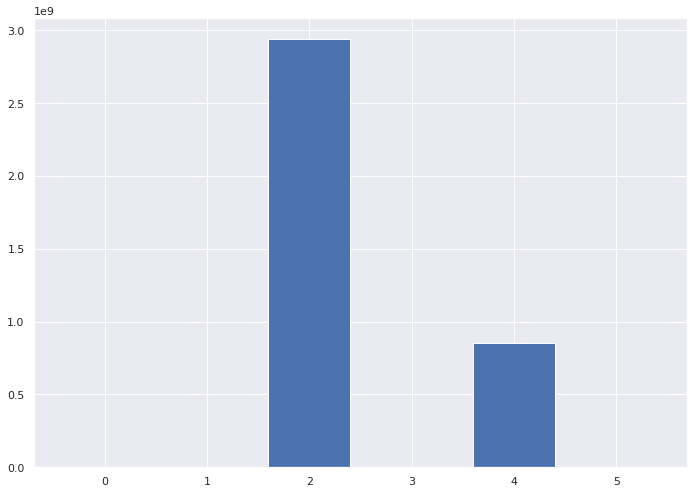

In [31]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

Features 0,2,3,4 are comparatively important

In [57]:
X_train_mod=X_train.drop(['type','isFlaggedFraud'],axis=1)

In [58]:
X_train_mod.columns

Index(['step', 'amount', 'nameOrig', 'nameDest'], dtype='object')

In [59]:
X_test_mod=X_test.drop(['type','isFlaggedFraud'],axis=1)

In [60]:
X_test_mod.columns

Index(['step', 'amount', 'nameOrig', 'nameDest'], dtype='object')

###Model Building

###2.Describe your fraud detection model in elaboration.

Decision Tree is a supervised learning algorithm.It is a non-parametric algorithm.It is used for both classificaation and regression tasks.Decision tree is a flow chart like structure.The internal nodes represent the test on a feature.leaf node represent class labels and branches are conjunctions of features that lead to that class label.At each node we ask a question and calculate the information gain.The split with the highest information gain will be taken as the first split.The process stops when the information gain is 0.

In [38]:
model=tree.DecisionTreeClassifier()

In [61]:
clf=model.fit(X_train_mod,y_train)

In [62]:
y_pred=model.predict(X_test_mod)

###4. Demonstrate the performance of the model by using best set of tools. 

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2007725
           1       0.44      0.46      0.45      2170

    accuracy                           1.00   2009895
   macro avg       0.72      0.73      0.72   2009895
weighted avg       1.00      1.00      1.00   2009895



In [64]:
model_score = accuracy_score(y_pred, y_test)
print("Our accuracy score:", model_score)

Our accuracy score: 0.9987790406961558


In [65]:
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.40624
Feature: 1, Score: 0.27079
Feature: 2, Score: 0.16804
Feature: 3, Score: 0.15493


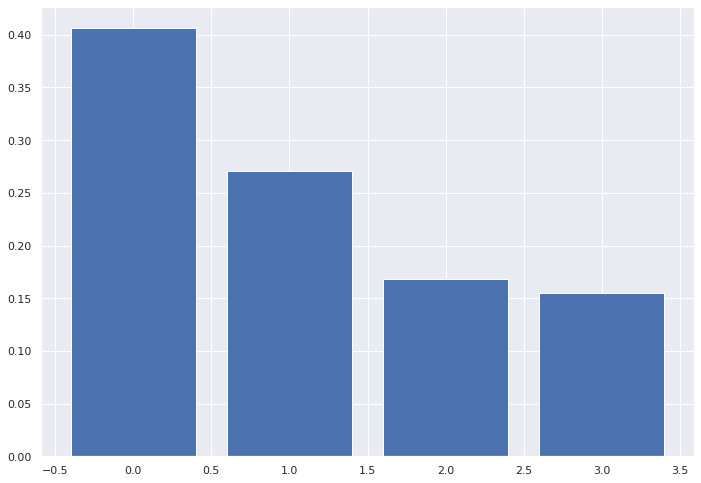

In [66]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

###5.What are the key factors that predict fraudulent customer?
       We can see time and amount is the most important features.

###6.Do these factors make sense? If yes, How? If not, How not?
Yes,these factors make sense.Fraud transaction may take more time. Unusual transfer of amount especially large amounts is suspectful.     

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.176372 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.176372 to fit



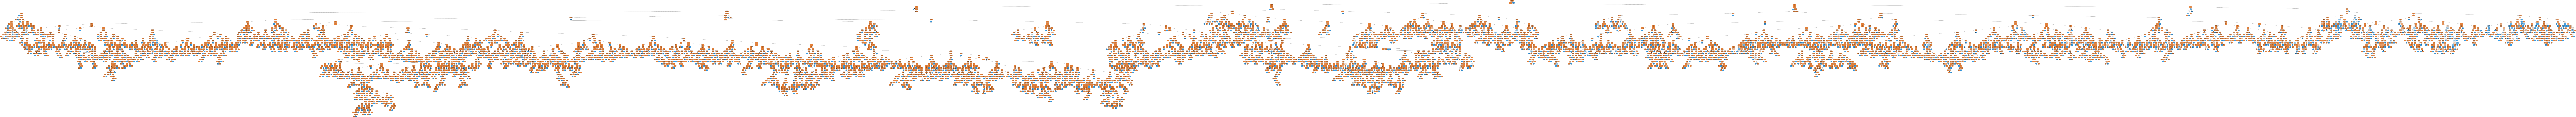

In [67]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('fraud_detect.png')
Image(graph.create_png())

###7.what kind of prevention should be adopted while company update its infrastructure?


Financial Institutions can use the power of AI to detect fraud actions. The high volume of transactional and customer data readily available in the financial services sector makes it ideal for the application of complex machine learning algorithm.As well as picking up known patterns, machine learning services are able to learn new patterns, without the need for human intervention. This allows models to adapt over time to uncover previously unknown patterns, or identify new tactics that might be employed by fraudsters.This type of artificial intelligence analyzes the user’s past behavior and essentially ‘learns’ from it in order to increase how accurate its results are.The past purchases will tell a little about the customer’s buying behavior. It will also detail out the amount they are likely to spend, the kind of purchases they make, and the locations. If the purchase is abnormal, then the algorithm will detect and prevent fraud. company should invest in good AI solutions for fraud detection.

###8.Assuming these actions have been implemented, how would you determine if they work?

The program should able to smoothly update the prediction model to take into account different tasks and data distributions but still being able to re-use and retain useful knowledge and skills during time.There should be quality assurance to make sure that the software system works according to the requirements.We should ensure that all the features are implemented as required.Also need to make sure that the program is behaving as expected.